# The Full Dataset
## Part 1: Data Extraction, GMM Fitting, and Visualization

This part focuses on loading the event log, converting it into a Pandas DataFrame, and extracting the "hour of day" from timestamps. A Gaussian Mixture Model (GMM) is then fitted to this extracted feature to identify patterns in the time-of-day data. The best GMM is selected based on the Bayesian Information Criterion (BIC), and its fit along with individual components are visualized.

## Implementation Steps:

1. **Load Data**: Import the BPI 2017 event log and convert it to a DataFrame.
2. **Extract Features**: Extract the "hour of day" from the timestamp.
3. **Fit GMM**: Fit a GMM for a range of components and select the model with the lowest BIC.
4. **Visualization**: Plot the density estimation and individual components of the best GMM.
5. **BIC Score**: Print the BIC score of the optimal GMM to evaluate its fit.


parsing log, completed traces ::   0%|          | 0/42995 [00:00<?, ?it/s]

The best GMM has 6 components with a BIC score of 584247.77.
Histogram Bin Centers: [1.18529287e-01 1.41474114e-01 1.68860586e-01 2.01548515e-01
 2.40564154e-01 2.87132416e-01 3.42715333e-01 4.09057958e-01
 4.88243148e-01 5.82756959e-01 6.95566695e-01 8.30214071e-01
 9.90926404e-01 1.18274933e+00 1.41170523e+00 1.68498226e+00
 2.01116010e+00 2.40047924e+00 2.86516255e+00 3.41979896e+00
 4.08180156e+00 4.87195421e+00 5.81506413e+00 6.94074070e+00
 8.28432505e+00 9.88799963e+00 1.18021126e+01 1.40867583e+01
 1.68136644e+01 2.00684433e+01 2.39532802e+01 2.85901416e+01
 3.41246038e+01 4.07304237e+01 4.86149943e+01 5.80258552e+01
 6.92584648e+01 8.26654761e+01 9.86678085e+01 1.17767863e+02
 1.40565294e+02 1.67775837e+02 2.00253781e+02 2.39018786e+02
 2.85287897e+02 3.40513754e+02 4.06430198e+02 4.85106708e+02
 5.79013368e+02]
Histogram Bin Heights: [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.31890419e-01 1.0852

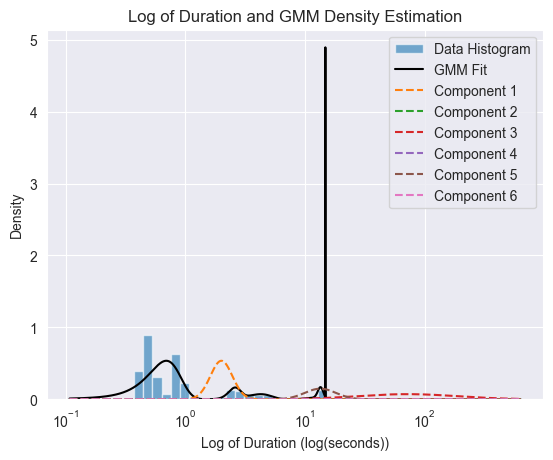

In [29]:
import pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Load BPI Challenge 2017 data
BPI2017 = "./BPI Challenge 2017 - Offer log.xes"
event_log = pm4py.read_xes(BPI2017)
data = pm4py.convert_to_dataframe(event_log)
# Sort the DataFrame by 'case:concept:name' and 'time:timestamp'
import pandas as pd

# Ensure that the 'time:timestamp' column is a datetime object
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# Group by 'case:concept:name' and sort by 'time:timestamp' within each group
data = data.sort_values(by=['case:concept:name', 'time:timestamp'])

# Shift the event details to get the start and end event in one row
data['end_event'] = data.groupby('case:concept:name')['concept:name'].shift(-1)
data['end_timestamp'] = data.groupby('case:concept:name')['time:timestamp'].shift(-1)
data['end_org:resource'] = data.groupby('case:concept:name')['org:resource'].shift(-1)
print()

# Calculate the duration in seconds
data['duration'] = (data['end_timestamp'] - data['time:timestamp']).dt.total_seconds()

# Keep only the relevant rows (where there is an end event)
data = data[~data['end_event'].isnull()]

# Select the columns to keep
columns_to_keep = [
    'case:concept:name', 'EventOrigin', 'concept:name', 'end_event',
    'duration', 'case:MonthlyCost', 'case:Selected', 'case:ApplicationID',
    'case:FirstWithdrawalAmount', 'case:CreditScore', 'case:OfferedAmount',
    'case:NumberOfTerms', 'case:Accepted', 'OfferID'
]

# Create a new DataFrame with the relevant data
processed_data = data[columns_to_keep].copy()

# Rename the columns for clarity
processed_data.rename(columns={
    'concept:name': 'start_event',
    'org:resource': 'start_org:resource',
    'time:timestamp': 'start_timestamp',
}, inplace=True)

# Your processed DataFrame is now ready and contains the duration between events, start event, end event, 
# and all the other applicable features for each case.
# Prepare data for GMM fitting
X = processed_data['duration'].values.reshape(-1, 1)
X_log_transformed = np.log(X + 1)

# Fit GMM and find the best model based on BIC
lowest_bic = np.infty
best_gmm = None
bic_list = []
n_components_range = range(1, 11)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
    gmm.fit(X_log_transformed)
    bic = gmm.bic(X_log_transformed)
    bic_list.append(bic)
    if bic < lowest_bic:
        lowest_bic, best_gmm = bic, gmm

# Show the best GMM
print(f"The best GMM has {best_gmm.n_components} components with a BIC score of {lowest_bic:.2f}.")

# Plot the histogram of the log-transformed durations and the density estimated by the best GMM
plt.figure()

# We use np.logspace to create bins on a log scale
bins = np.logspace(np.log(X_log_transformed.min()), np.log(X_log_transformed.max()), 50)

# Histogram data
hist_data, bin_edges = np.histogram(X.flatten(), bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.hist(X_log_transformed.flatten(), bins=bins, density=True, alpha=0.6, label='Data Histogram')
plt.xscale('log')  # Set the x-axis to a log scale

x_plot = np.logspace(np.log(X_log_transformed.min()), np.log(X_log_transformed.max()), 45000).reshape(-1, 1)
logprob = best_gmm.score_samples(x_plot)
pdf = np.exp(logprob)

plt.plot(x_plot, pdf, '-k', label='GMM Fit')

# Plot each individual GMM component
for i in range(best_gmm.n_components):
    weight = best_gmm.weights_[i]
    mean = best_gmm.means_[i, 0]
    covariance = best_gmm.covariances_[i, 0, 0]
    individual_pdf = weight * norm.pdf(np.log(x_plot).flatten(), mean, np.sqrt(covariance))
    plt.plot(x_plot, individual_pdf, '--', label=f'Component {i+1}')

# GMM parameters
gmm_means = best_gmm.means_.flatten()
gmm_variances = best_gmm.covariances_.flatten()
gmm_weights = best_gmm.weights_.flatten()

# Now, print or store the values you need
print("Histogram Bin Centers:", bin_centers)
print("Histogram Bin Heights:", hist_data)
print("Bin Edges:", bin_edges)
print("GMM Means:", gmm_means)
print("GMM Variances:", gmm_variances)
print("GMM Weights:", gmm_weights)

plt.title('Log of Duration and GMM Density Estimation')
plt.xlabel('Log of Duration (log(seconds))')
plt.ylabel('Density')
plt.legend()
plt.show()

# The Segmented Dataset

## Part 2: Detailed Exploration through Recursive Partitioning

After initial assessments with the whole dataset, we delve deeper by dissecting the data into more homogenous segments. This step employs recursive partitioning, focusing on pivotal features to identify subsets that share common characteristics. Each subset is then modeled using Gaussian Mixture Models (GMM) to grasp the underlying distribution of events over time. This intricate process allows for a nuanced understanding of the data's structure and variability.

### Implementation Steps:

1. **Feature Identification using Decision Trees**: Utilize a Decision Tree Regressor to pinpoint the most influential feature that impacts the timing of events. This method ensures that the partitioning is guided by data-driven insights, leading to meaningful segmentation.

2. **Recursive Partitioning**: Systematically divide the dataset based on the identified feature. This process is recursive, meaning it repeats this division within each resulting subset until a specified depth or minimum subset size is reached. This iterative approach ensures that even the most granular patterns can be uncovered.

3. **Gaussian Mixture Modeling**: For each subset created through partitioning, a GMM is fitted. This step is crucial for understanding how events are distributed over time within each segment. By modeling these distributions, we can identify unique patterns that were not apparent in the aggregated data.

4. **Visual Analysis**: Select subsets are visualized to showcase their GMM fits, providing a graphical representation of the time-based event distribution and the effectiveness of the segmentation.

5. **Averaging Metrics**: Aggregate measures, including the average BIC score and the average number of components across all subsets, are computed. These metrics offer insights into the overall complexity and homogeneity of the data after segmentation. Lower BIC scores and fewer components suggest that the recursive partitioning has successfully identified more uniform groups within the data.

Conditions for subset 2462: start_event=O_Created, Cluster 4, end_event=O_Sent (mail and online), case:Accepted=True, Cluster 0, Cluster 8, Cluster 0, Cluster 2


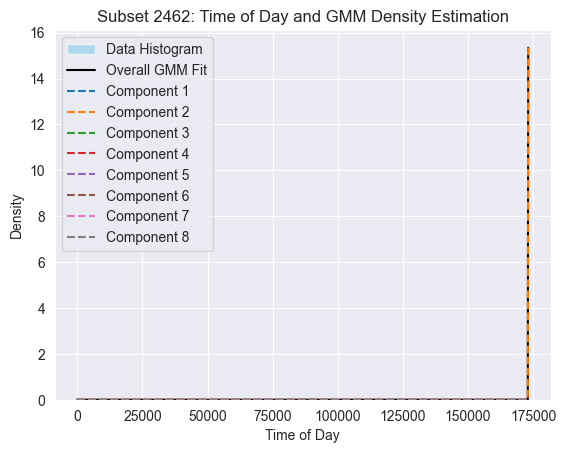

Histogram Bin Centers: [  3614.46960417  10826.3988125   18038.32802083  25250.25722917
  32462.1864375   39674.11564583  46886.04485417  54097.9740625
  61309.90327083  68521.83247917  75733.7616875   82945.69089583
  90157.62010417  97369.5493125  104581.47852083 111793.40772917
 119005.3369375  126217.26614583 133429.19535417 140641.1245625
 147853.05377083 155064.98297917 162276.9121875  169488.84139583]
Histogram Bin Heights: [1.33326109e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 5.33304437e-06]
Bin Edges: [8.50500000e+00 7.22043421e+03 1.44323634e+04 2.16442926e+04
 2.88562218e+04 3.60681510e+04 4.32800802e+04 5.04920095e+04
 5.77039387e+04 6.49158679e+04 7.21277971e+04 7.93397263e+04
 8.6

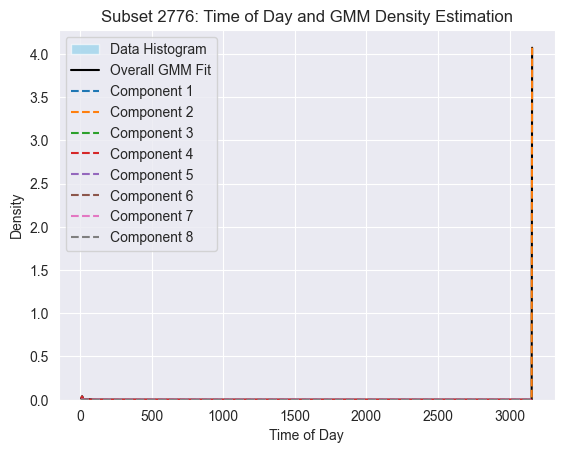

Histogram Bin Centers: [  72.4458125  203.7214375  334.9970625  466.2726875  597.5483125
  728.8239375  860.0995625  991.3751875 1122.6508125 1253.9264375
 1385.2020625 1516.4776875 1647.7533125 1779.0289375 1910.3045625
 2041.5801875 2172.8558125 2304.1314375 2435.4070625 2566.6826875
 2697.9583125 2829.2339375 2960.5095625 3091.7851875]
Histogram Bin Heights: [6.21841664e-03 7.77302080e-04 1.55460416e-04 2.33190624e-04
 0.00000000e+00 0.00000000e+00 7.77302080e-05 7.77302080e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 7.77302080e-05]
Bin Edges: [   6.808     138.083625  269.35925   400.634875  531.9105    663.186125
  794.46175   925.737375 1057.013    1188.288625 1319.56425  1450.839875
 1582.1155   1713.391125 1844.66675  1975.942375 2107.218    2238.493625
 2369.76925  2501.044875 2632.3205   27

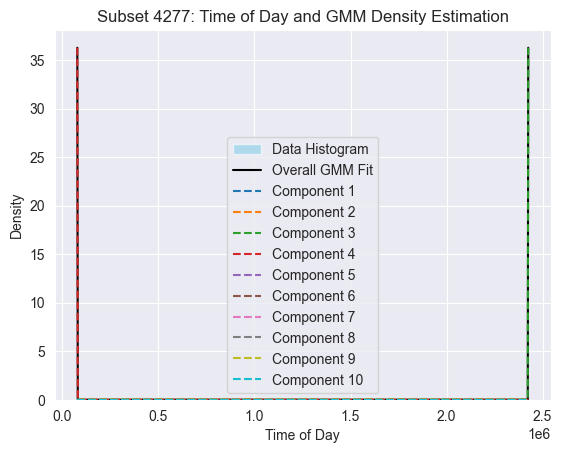

Histogram Bin Centers: [ 126522.62089583  224337.5746875   322152.52847917  419967.48227083
  517782.4360625   615597.38985417  713412.34364583  811227.2974375
  909042.25122917 1006857.20502083 1104672.1588125  1202487.11260417
 1300302.06639583 1398117.0201875  1495931.97397917 1593746.92777083
 1691561.8815625  1789376.83535417 1887191.78914583 1985006.7429375
 2082821.69672917 2180636.65052083 2278451.6043125  2376266.55810417]
Histogram Bin Heights: [1.8587974e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.2939870e-07
 3.7175948e-06 0.0000000e+00 9.2939870e-07 0.0000000e+00 0.0000000e+00
 9.2939870e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 9.2939870e-07 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.2939870e-07]
Bin Edges: [  77615.144       175430.09779167  273245.05158333  371060.005375
  468874.95916667  566689.91295833  664504.86675     762319.82054167
  860134.77433333  957949.728125   1055764.68191667 

/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [30]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import random

# Function to identify the most important feature
def train_decision_tree_and_identify_important_feature_optimized(data, target_column_name):
    data_copy = data.copy()
    if not np.issubdtype(data_copy[target_column_name].dtype, np.number):
        data_copy[target_column_name] = pd.to_numeric(data_copy[target_column_name], errors='coerce')
    data_copy = data_copy.dropna(subset=[target_column_name])

    categorical_cols = data_copy.select_dtypes(include=['object', 'bool']).columns
    le = LabelEncoder()
    for column in categorical_cols:
        data_copy[column] = le.fit_transform(data_copy[column].astype(str))

    cols_to_drop = ['case:ApplicationID', 'EventID', 'time:timestamp']
    data_copy = data_copy.drop(columns=cols_to_drop, errors='ignore')

    X = data_copy.drop(columns=[target_column_name])
    y = data_copy[target_column_name].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    tree_reg = DecisionTreeRegressor(random_state=42)
    tree_reg.fit(X_train, y_train)

    feature_importances = tree_reg.feature_importances_
    most_important_feature_index = np.argmax(feature_importances)
    most_important_feature_name = X.columns[most_important_feature_index]

    return most_important_feature_name

def segment_data_based_on_feature(current_data, feature_name):
    segmented_data = {}
    feature_values = current_data[feature_name].values

    if np.issubdtype(current_data[feature_name].dtype, np.number):
        unique_values = np.unique(feature_values)
        if len(unique_values) > 10:  # Adjust this threshold as needed
            feature_values_reshaped = feature_values.reshape(-1, 1)
            n_components_range = range(1, min(len(unique_values), 11))
            models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(feature_values_reshaped) for n in n_components_range]
            best_gmm = min(models, key=lambda model: model.bic(feature_values_reshaped))
            clusters = best_gmm.predict(feature_values_reshaped)
            current_data['cluster'] = clusters
            for cluster in np.unique(clusters):
                cluster_data = current_data[current_data['cluster'] == cluster]
                segmented_data[f'Cluster {cluster}'] = cluster_data.drop(columns=['cluster'])
        else:
            for value in unique_values:
                segmented_data[f'{feature_name}={value}'] = current_data[current_data[feature_name] == value]
    else:
        unique_values = current_data[feature_name].unique()
        for value in unique_values:
            segmented_data[f'{feature_name}={value}'] = current_data[current_data[feature_name] == value]

    return segmented_data

def recursive_partition(current_data, excluded_features, threshold, max_depth, current_depth=0, conditions=[]):
    if current_depth >= max_depth or len(current_data) <= threshold:
        return [(conditions, current_data)]

    features = [col for col in current_data.columns if col not in excluded_features + ['duration']]
    data_for_tree = current_data[features + ['duration']].dropna()
    if data_for_tree.empty or len(features) == 0:
        return [(conditions, current_data)]

    important_feature = train_decision_tree_and_identify_important_feature_optimized(data_for_tree, 'duration')
    if important_feature not in excluded_features:
        partitions = segment_data_based_on_feature(current_data, important_feature)
        results = []
        for segment_key, segment_data in partitions.items():
            new_conditions = conditions + [segment_key]
            results += recursive_partition(segment_data, excluded_features + [important_feature], threshold, max_depth, current_depth + 1, new_conditions)
        return results
    else:
        return [(conditions, current_data)]

def plot_subset_gmm_with_components(current_data, subset_index):
    subset_conditions, subset_data = final_partitions[subset_index]
    conditions_str = ', '.join(subset_conditions) if subset_conditions else "No conditions (initial dataset)"
    print(f"Conditions for subset {subset_index}: {conditions_str}")

    # Prepare the data for GMM fitting
    X = subset_data['duration'].values.reshape(-1, 1)

    if len(X) > 1:  # Ensure there are enough samples for GMM fitting
        n_components_range = range(1, min(len(X), 11))
        best_gmm = None
        lowest_bic = np.infty
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0).fit(X)
            bic = gmm.bic(X)
            if bic < lowest_bic:
                lowest_bic = bic
                best_gmm = gmm

        # Plotting the overall GMM fit
        plt.hist(X.flatten(), bins=24, density=True, alpha=0.6, color='skyblue', label='Data Histogram')
        x = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
        logprob = best_gmm.score_samples(x)
        pdf = np.exp(logprob)
        plt.plot(x, pdf, '-k', label='Overall GMM Fit')

        # Plotting each component
        for i in range(best_gmm.n_components):
            mean = best_gmm.means_[i][0]
            cov = best_gmm.covariances_[i][0][0]
            component_pdf = np.exp(-0.5 * (x - mean) ** 2 / cov) / np.sqrt(2 * np.pi * cov) * best_gmm.weights_[i]
            plt.plot(x, component_pdf, '--', label=f'Component {i+1}')

        plt.title(f'Subset {subset_index}: Time of Day and GMM Density Estimation')
        plt.xlabel('Time of Day')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

        # Additional Information
        # Histogram Data
        hist_data, bin_edges = np.histogram(X, bins=24, density=True)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

        # GMM Parameters
        gmm_means = best_gmm.means_.flatten()
        gmm_variances = best_gmm.covariances_.flatten()
        gmm_weights = best_gmm.weights_.flatten()

        print("Histogram Bin Centers:", bin_centers)
        print("Histogram Bin Heights:", hist_data)
        print("Bin Edges:", bin_edges)
        print("GMM Means:", gmm_means)
        print("GMM Variances:", gmm_variances)
        print("GMM Weights:", gmm_weights)

    else:
        print("Not enough data for GMM fitting.")
        
# Function to calculate averages
def calculate_averages(final_partitions):
    total_components = 0
    total_bic = 0
    for _, subset_data in final_partitions:
        X = subset_data['duration'].values.reshape(-1, 1)
        if len(X) > 1:
            n_components_range = range(1, min(len(X), 11))
            lowest_bic = np.infty
            best_n_components = None
            for n_components in n_components_range:
                gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0).fit(X)
                bic = gmm.bic(X)
                if bic < lowest_bic:
                    lowest_bic = bic
                    best_n_components = n_components
            total_components += best_n_components
            total_bic += lowest_bic
    average_components = total_components / len(final_partitions)
    average_bic = total_bic / len(final_partitions)
    return average_components, average_bic

random_indices = random.sample(range(len(final_partitions)), min(3, len(final_partitions)))
for index in random_indices:
    plot_subset_gmm_with_components(data.copy(), index)
    
excluded_features = ['case:ApplicationID', 'OfferID', 'EventID', 'EventOrigin', 'case:concept:name', 'cluster', 'time:timestamp']
final_partitions = recursive_partition(processed_data.copy(), excluded_features, 100, 4)
average_components, average_bic_total_subsets = calculate_averages(final_partitions)
print(final_partitions)
print(f"Average number of GMM components: {average_components}")
print(f"Average BIC score: {average_bic_total_subsets}")

# Subsets that are modelled with one normal distribution component
## Part 3: Single-Component Optimal Fit Filtering and Averages Calculation

In this section, the aim is to refine our analysis by focusing on subsets where a Gaussian Mixture Model (GMM) with a single component is deemed optimal. This constraint allows for a more targeted examination of data segments that exhibit a relatively uniform distribution of event times throughout the day.

## Steps:

1. **Filtering**: Exclude subsets that are best modeled with more than one GMM component.
2. **Average BIC Calculation**: Calculate the average Bayesian Information Criterion (BIC) score across the filtered subsets to evaluate the fit's quality.
3. **Interpretation**: The resulting average provides insights into how well a simple model can represent the data, offering a perspective on the underlying process complexity.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Average BIC score for subsets best modeled with a single GMM component: 1971.47
Number of subsets with a single component optimal: 2


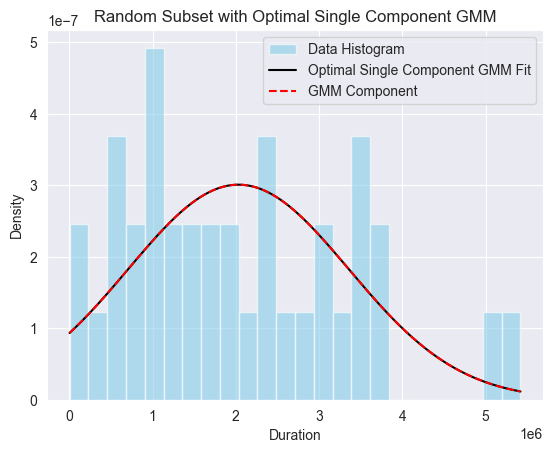

In [31]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import random

# Function to filter subsets optimally modeled by a single GMM component and calculate their BIC scores
def filter_and_calculate_bic_single_component_subsets(final_partitions):
    bic_scores = []
    single_component_subsets = []

    for partition in final_partitions:
        _, subset_data = partition
        X = subset_data['duration'].values.reshape(-1, 1)
        if len(X) > 1:
            best_bic = np.inf
            best_model = None
            for n_components in range(1, min(11, len(X) + 1)):
                gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=0).fit(X)
                bic = gmm.bic(X)
                if bic < best_bic:
                    best_bic = bic
                    best_model = gmm
            # Check if the best model for this subset has exactly one component
            if best_model.n_components == 1:
                bic_scores.append(best_bic)
                single_component_subsets.append((best_model, X))

    return bic_scores, single_component_subsets

# Assuming final_partitions is already defined from the segmentation step
bic_scores, single_component_subsets = filter_and_calculate_bic_single_component_subsets(final_partitions)

# Calculate and print the average BIC score across subsets optimally modeled with a single component
if bic_scores:
    average_bic_single_component = np.mean(bic_scores)
    print(f"Average BIC score for subsets best modeled with a single GMM component: {average_bic_single_component:.2f}")
    print(f"Number of subsets with a single component optimal: {len(bic_scores)}")
else:
    print("No subsets are best modeled with a single GMM component.")

# Plotting one of the subsets randomly if available
if single_component_subsets:
    best_model, X = random.choice(single_component_subsets)
    plt.hist(X.flatten(), bins=24, density=True, alpha=0.6, color='skyblue', label='Data Histogram')
    x = np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)
    logprob = best_model.score_samples(x)
    pdf = np.exp(logprob)
    plt.plot(x, pdf, '-k', label='Optimal Single Component GMM Fit')

    # Since it's a single component, extract its mean and covariance for plotting
    mean = best_model.means_[0]
    covariance = best_model.covariances_[0]
    component_pdf = np.exp(-0.5 * (x - mean) ** 2 / covariance) / np.sqrt(2 * np.pi * covariance)
    plt.plot(x, component_pdf, '--r', label='GMM Component')

    plt.title("Random Subset with Optimal Single Component GMM")
    plt.xlabel("Duration")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
else:
    print("No suitable subsets for plotting.")

# Comparing the Models
## Part 4: Comparison of BIC Scores Across Different Models
In this part, we compare the Bayesian Information Criterion (BIC) scores obtained from three different modeling approaches to understand their effectiveness in capturing the underlying distribution of the data:

1. **Overall Data Model**: The BIC score for the entire dataset modeled with a Gaussian Mixture Model (GMM) to find the best fit.
2. **Segmented Subsets Model**: After segmenting the data based on significant features, we model each subset with GMMs and calculate the average BIC score across all subsets.
3. **Single-Component Subsets Model**: Focusing on subsets that are optimally modeled with a single component GMM, we calculate the average BIC score for these subsets.

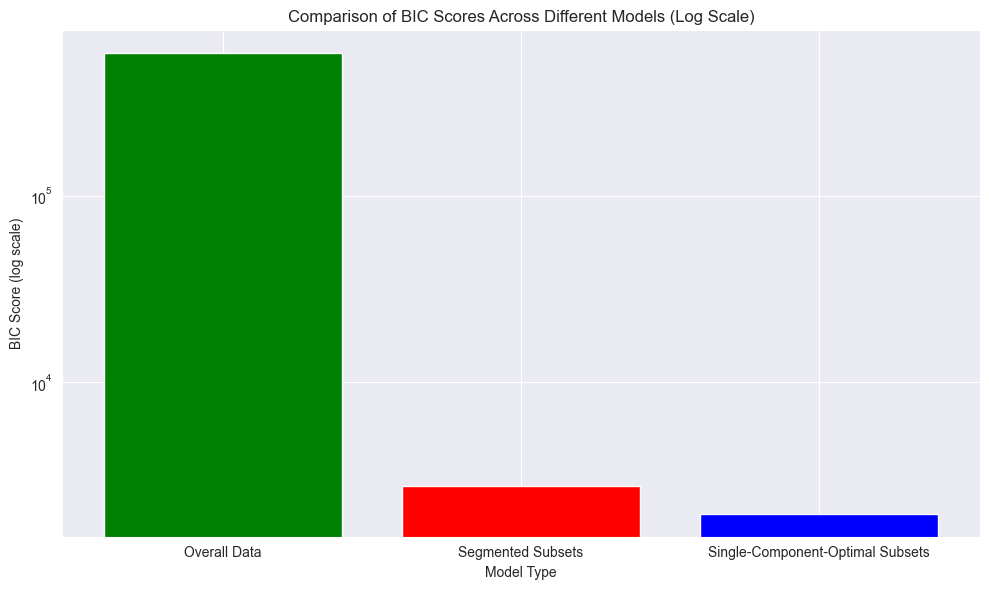

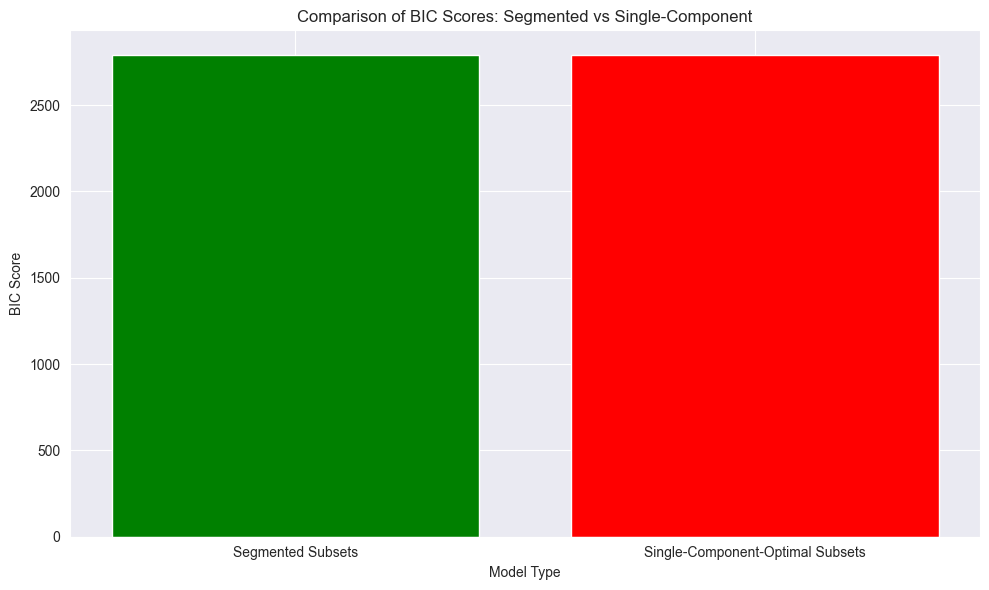

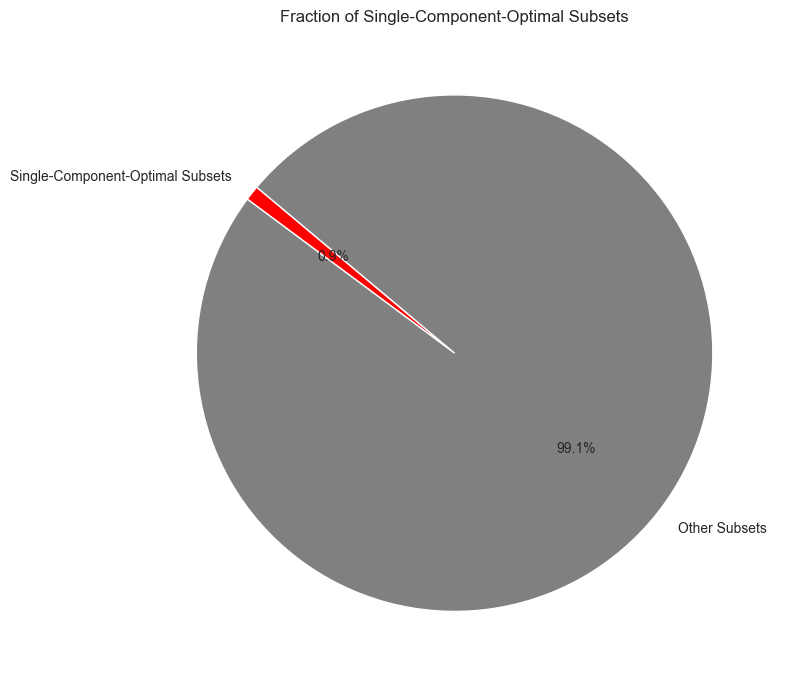

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Labels for each category
categories = ['Overall Data', 'Segmented Subsets', 'Single-Component-Optimal Subsets']
categories_comparison = ['Segmented Subsets', 'Single-Component-Optimal Subsets']

# BIC scores for each category
bic_scores = [lowest_bic, average_bic_total_subsets, average_bic_single_component]
bic_scores_comparison = [average_bic_total_subsets]

# Creating the bar chart with a logarithmic scale
plt.figure(figsize=(10, 6))
plt.bar(categories, bic_scores, color=['green', 'red', 'blue'])
plt.yscale('log')  # Applying logarithmic scale

# Adding the title and labels
plt.title('Comparison of BIC Scores Across Different Models (Log Scale)')
plt.ylabel('BIC Score (log scale)')
plt.xlabel('Model Type')

# Showing the plot with log scale
plt.tight_layout()
plt.show()

# Creating a separate bar chart with a normal scale for segmented vs single-component
plt.figure(figsize=(10, 6))
plt.bar(categories_comparison, bic_scores_comparison, color=['green', 'red'])

# Adding the title and labels for the comparison
plt.title('Comparison of BIC Scores: Segmented vs Single-Component')
plt.ylabel('BIC Score')
plt.xlabel('Model Type')

# Showing the plot with normal scale
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Number of subsets
total_subsets_count = len(final_partitions)  # Assuming 'final_partitions' contains all subsets
single_component_optimal_count = len(single_component_subsets)  # Assuming 'single_component_subsets' contains only those optimal for a single component

# Calculating fractions
fractions = [single_component_optimal_count, total_subsets_count - single_component_optimal_count]
labels = ['Single-Component-Optimal Subsets', 'Other Subsets']

# Creating the pie chart
plt.figure(figsize=(8, 8))
plt.pie(fractions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['red', 'grey'])

plt.title('Fraction of Single-Component-Optimal Subsets')
plt.tight_layout()
plt.show()


/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

(467168.7062236279, 79520.79528495284, 2792.489851577639, 369.25060819829025)


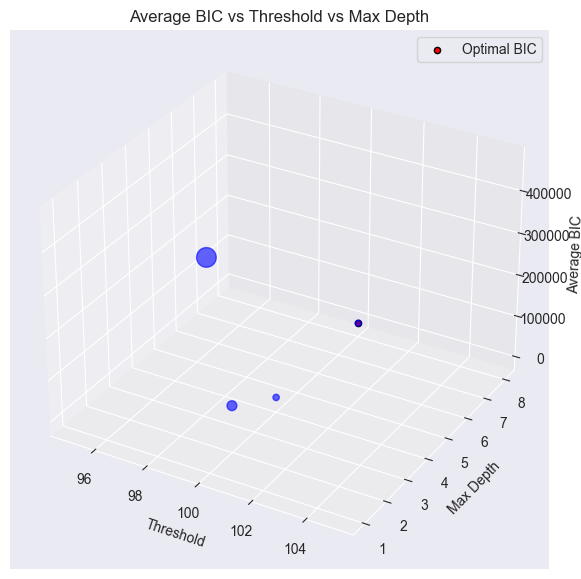

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming data is prepared and final_partitions is generated correctly

# Define ranges of parameters to test
thresholds = [100]  # Example threshold values
depths = [1,2,4,8]  # Example max_depth values

# Prepare to store results
results = []

# Nested loop over both thresholds and depths
for threshold in thresholds:
    for depth in depths:
        final_partitions = recursive_partition(processed_data.copy(), excluded_features, threshold, depth)
        _, average_bic = calculate_averages(final_partitions)
        results.append((threshold, depth, average_bic))

# Extracting results for plotting
thresholds, depths, bics = zip(*results)
print(bics)
# Normalize BIC values for point sizes, ensure division by zero is handled
bic_min = min(bics)
bic_max = max(bics)
sizes = [20 + 180 * (bic - bic_min) / (bic_max - bic_min) if bic_max - bic_min > 0 else 100 for bic in bics]

# Find optimal combination (minimal BIC)
optimal_index = np.argmin(bics)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for all combinations
ax.scatter(thresholds, depths, bics, s=sizes, c='blue', alpha=0.6)

# Highlight the optimal combination
ax.scatter([thresholds[optimal_index]], [depths[optimal_index]], [bics[optimal_index]], s=[sizes[optimal_index]], c='red', alpha=1, edgecolor='black', label='Optimal BIC')

# Adding labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Max Depth')
ax.set_zlabel('Average BIC')
ax.set_title('Average BIC vs Threshold vs Max Depth')
ax.legend()

plt.show()

In [34]:
print()

In [35]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Assuming 'data' is your DataFrame prepared for the analysis

# Define the range of values for threshold and max depth
threshold_values = np.arange(1000, 12001, 2000)  # Example: from 100 to 1000 in steps of 100
max_depth_values = np.arange(1, 11, 1)  # Example: from 1 to 10 in steps of 1

# Lists to store execution times
times_threshold = []
times_depth = []

# Measure time for varying thresholds
for threshold in threshold_values:
    start_time = time.time()
    final_partitions = recursive_partition(processed_data.copy(), excluded_features, threshold, 5)  # Use a default depth value that makes sense for your dataset
    calculate_averages(final_partitions)
    end_time = time.time()
    times_threshold.append(end_time - start_time)

# Measure time for varying max depths
for max_depth in max_depth_values:
    start_time = time.time()
    final_partitions = recursive_partition(processed_data.copy(), excluded_features, 1000, max_depth)  # Use a default threshold that makes sense for your dataset
    calculate_averages(final_partitions)
    end_time = time.time()
    times_depth.append(end_time - start_time)

# Plotting the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(threshold_values, times_threshold, marker='o', color='blue')
plt.title('Execution Time vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Time (seconds)')

plt.subplot(1, 2, 2)
plt.plot(max_depth_values, times_depth, marker='o', color='green')
plt.title('Execution Time vs. Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Time (seconds)')

plt.tight_layout()
plt.show()

/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_data['cluster'] = clusters
/var/folders/lw/172xjw0s2z53p0jbvr5t3nx80000gn/T/ipykernel_10481/2297707951.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

KeyboardInterrupt: 

In [ ]:
print(threshold_values)
print(times_threshold)
print(max_depth_values)
print(times_depth)

In [ ]:
print(bics)
print(depths)
print(thresholds)

In [ ]:
print(categories)
print(bic_scores)

In [38]:
print(average_bic_single_component)
print(average_bic_total_subsets)
print(lowest_bic)

1971.4686764164016
2792.489851577639
584247.7657205364
